STEP 1: LOAD AND EXPLORE THE EXTERNAL DATASET 

For my external dataset i use the U.S. CENSUS BUREAU'S AMERICAN COMMUNITY SURVEY (ACS) 2023 5 YEAR ESIMATES
Specially, I fetch table B19013(Median Household Income) at the census tract level for Los Angeles County (state FIPS 06, county FIPS 037) using the Census API.
This dataset provides neighborhood-level socioeconomic context that is not present in the LAPD crime dataset.
The key variables include:
median_income — median household income for each census tract

tract_geoid — 11-digit geographic identifier (state + county + tract)

NAME — readable tract name, useful for validation

These variables will allow us to attach real socioeconomic information to each crime location once I map crimes to census tracts using latitude and longitude.


In [20]:
import requests
import pandas as pd

# =========================
# Step 1 – Load External ACS Dataset via Census API
# =========================

# ACS 2023 5-year, table B19013 (median household income)
# Geography: all tracts in California (state 06), Los Angeles County (county 037)
url = (
    "https://api.census.gov/data/2023/acs/acs5"
    "?get=B19013_001E,NAME&for=tract:*&in=state:06%20county:037"
)

response = requests.get(url)
response.raise_for_status()  # will throw an error if the request fails

data = response.json()

# First row = header, rest = data
acs = pd.DataFrame(data[1:], columns=data[0])

# Rename median income column to something clear
acs = acs.rename(columns={"B19013_001E": "median_income"})

# Convert median_income to numeric (Census API returns strings)
acs["median_income"] = pd.to_numeric(acs["median_income"], errors="coerce")

# Build an 11-digit tract GEOID: state (2) + county (3) + tract (6)
acs["tract_geoid"] = (
    acs["state"].str.zfill(2)
    + acs["county"].str.zfill(3)
    + acs["tract"].str.zfill(6)
)

# Keep only the useful columns
acs = acs[["tract_geoid", "median_income", "NAME"]]

print("ACS shape:", acs.shape)
acs.head()

# Replace ACS invalid suppressed values
acs["median_income"] = acs["median_income"].replace(-666666666, pd.NA)



ACS shape: (2498, 3)


STEP 2 IDENTIFY AND ALIGN LINKING KEYS


The ACS income data is reported at the census tract level and includes a geographic identifier called tract_geoid.
My LAPD crime dataset does not contain census tracts directly, but it does include latitude and longitude coordinates (LAT, LON) for each incident.

To align the two datasets:

I load the official Los Angeles County census tract shapefile.

I construct a matching tract_geoid in the shapefile using
STATEFP + COUNTYFP + TRACTCE.

I convert the crime dataset to geographic points (using LAT/LON).

I perform a spatial join, assigning each crime incident to the tract in which it occurred.

This process creates a new column called tract_geoid in the crime dataset that matches the key in the ACS dataset, allowing me to merge demographic context into the crime data in the next step.

In [21]:
#Step 2A creating the key in the geography data
import geopandas as gpd

# Path for tract shapefile (California tracts)
TRACT_SHP = (
    "/Users/diyapatel/Desktop/DTSC 3602 /PROJECT/Data Integration & Cleaning Notebook "
    "/tl_2023_06_tract/tl_2023_06_tract.shp"
)

# 1. Loaded all California census tracts
tracts = gpd.read_file(TRACT_SHP)
print("All CA tracts shape:", tracts.shape)
print(tracts.columns[:10])

# 2. Filter to just Los Angeles County (COUNTYFP == '037')
la_tracts = tracts[tracts["COUNTYFP"] == "037"].copy()
print("LA tracts shape:", la_tracts.shape)

# 3. Built tract_geoid to match the ACS DataFrame
la_tracts["tract_geoid"] = (
    la_tracts["STATEFP"].astype(str).str.zfill(2)
    + la_tracts["COUNTYFP"].astype(str).str.zfill(3)
    + la_tracts["TRACTCE"].astype(str).str.zfill(6)
)

la_tracts[["STATEFP", "COUNTYFP", "TRACTCE", "tract_geoid"]].head()


All CA tracts shape: (9129, 14)
Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND'],
      dtype='object')
LA tracts shape: (2498, 14)


,STATEFP,COUNTYFP,TRACTCE,tract_geoid
2,06,037,204920,06037204920
3,06,037,205110,06037205110
4,06,037,320101,06037320101
5,06,037,205120,06037205120
6,06,037,206010,06037206010


### Step 2B: Attach Census Tract Keys to Crime Records

Now that I have `tract_geoid` defined for Los Angeles census tracts, I need to attach this key to each crime incident. The LAPD dataset does not include tracts directly, but it does have latitude and longitude (`LAT`, `LON`) for every record.

In this step, I:

1. Convert the crime dataset into a GeoDataFrame using `LAT` and `LON` as point geometries.
2. Ensure that the crime points and tract polygons share the same coordinate reference system (CRS).
3. Perform a spatial join so that each crime is assigned to the tract polygon it falls within.
4. This adds a `tract_geoid` column to the crime data, which matches the ACS `tract_geoid` and will be used for merging in Step 4.


In [22]:
# STEPP 2B Attaching that key to the crime records
CRIME_CSV = "/Users/diyapatel/Desktop/cleaned_property_crimes.csv"

crime = pd.read_csv(CRIME_CSV, low_memory=False)

crime_gdf = gpd.GeoDataFrame(
    crime.copy(),
    geometry=gpd.points_from_xy(crime["LON"], crime["LAT"]),
    crs="EPSG:4326"
)

if la_tracts.crs is None:
    la_tracts = la_tracts.set_crs("EPSG:4269")
if la_tracts.crs != crime_gdf.crs:
    la_tracts = la_tracts.to_crs(crime_gdf.crs)

la_tracts_small = la_tracts[["tract_geoid", "geometry"]].copy()

crime_with_tract = gpd.sjoin(
    crime_gdf,
    la_tracts_small,
    how="left",
    predicate="within"
)

if "index_right" in crime_with_tract.columns:
    crime_with_tract = crime_with_tract.drop(columns=["index_right"])

crime_with_tract[["DATE OCC", "AREA NAME", "LAT", "LON", "tract_geoid"]].head()


,DATE OCC,AREA NAME,LAT,LON,tract_geoid
0,2020-11-07,N Hollywood,34.2124,-118.4092,06037121600
1,2020-10-30,Van Nuys,34.1847,-118.4509,06037128303
2,2020-12-24,Wilshire,34.0339,-118.3747,06037270200
3,2020-09-29,Pacific,33.9813,-118.4350,06037275312
4,2020-11-11,Hollenbeck,34.0830,-118.1678,06037201501


STEP 3 CLEAN AND STANDARIZED BOTH DATASETS


Before merging, I standardize the key and important variables in both datasets:

- I ensure that `tract_geoid` is stored as a string in both the crime data and the ACS data.
- I verify that `median_income` is numeric in the ACS dataset.
- I check for missing values in the tract key and income to understand how complete the join will be.
- I optionally drop crime records that are missing a tract (e.g., points that fall outside the LA tract boundaries or have invalid coordinates).

This step helps prevent mismatched keys, type errors, and unexpected NaNs after merging.


In [23]:
# =========================
# Step 3 – Clean & Standardize Keys and Types
# =========================

# 1. Making sure tract_geoid is string in both datasets
crime_with_tract["tract_geoid"] = crime_with_tract["tract_geoid"].astype("string")
acs["tract_geoid"] = acs["tract_geoid"].astype("string")

# 2. Making sure median_income is numeric (should already be, but we confirm)
acs["median_income"] = pd.to_numeric(acs["median_income"], errors="coerce")

# 3. Quick null checks for key + income
print("Missing values in key / income:")
print(" - Crime tract_geoid null:", crime_with_tract["tract_geoid"].isna().sum())
print(" - ACS tract_geoid null:", acs["tract_geoid"].isna().sum())
print(" - ACS median_income null:", acs["median_income"].isna().sum())

# Optional: see overall missingness in key columns
key_null_summary = pd.DataFrame({
    "dataset": ["crime_with_tract", "acs"],
    "null_tract_geoid": [
        crime_with_tract["tract_geoid"].isna().sum(),
        acs["tract_geoid"].isna().sum()
    ]
})
key_null_summary


Missing values in key / income:
 - Crime tract_geoid null: 515
 - ACS tract_geoid null: 0
 - ACS median_income null: 45


,dataset,null_tract_geoid
0,crime_with_tract,515
1,acs,0


## Step 4: Merge the Datasets

Now that both datasets share a cleaned and standardized key (`tract_geoid`), I can merge the ACS median income data into the crime dataset.

Before merging, I removed crime incidents where `tract_geoid` was missing (about 515 rows). These points fell outside of Los Angeles County tract boundaries or contained invalid coordinates, so keeping them would introduce unnecessary missing values in the merged dataset.

I perform a left merge, keeping all crime records that have a valid tract and attaching the corresponding `median_income` from the ACS dataset. After merging, I check a few sample rows to verify that `median_income` was successfully added.


In [24]:
# =========================
# Step 4 – Merge Crime Data with ACS Income Data
# =========================

# Used the cleaned crime dataset (without missing tract_geoid)
crime_clean = crime_with_tract.dropna(subset=["tract_geoid"]).copy()

print("Crime rows before merge:", len(crime_clean))
print("ACS rows:", len(acs))

# Merged on the tract key
merged = crime_clean.merge(
    acs[["tract_geoid", "median_income"]],
    on="tract_geoid",
    how="left"
)

print("Merged shape:", merged.shape)

# Checked that median_income successfully attached
merged[["DATE OCC", "AREA NAME", "tract_geoid", "median_income"]].head()


Crime rows before merge: 408306
ACS rows: 2498
Merged shape: (408306, 18)


,DATE OCC,AREA NAME,tract_geoid,median_income
0,2020-11-07,N Hollywood,06037121600,95250.0
1,2020-10-30,Van Nuys,06037128303,43750.0
2,2020-12-24,Wilshire,06037270200,80563.0
3,2020-09-29,Pacific,06037275312,177963.0
4,2020-11-11,Hollenbeck,06037201501,90074.0


## Step 5: Create New Contextual Features

After merging the ACS income data into the crime dataset, I generated new derived features that provide socioeconomic context for each incident. These features help capture how neighborhood-level conditions may relate to crime patterns, model interpretability, or fairness considerations.

### **1. Income Quartile (`income_quartile`)**
I divided median household incomes into four quartiles across all Los Angeles census tracts.  
- Quartile 1 = lowest income neighborhoods  
- Quartile 4 = highest income neighborhoods  

This variable lets me compare crime patterns across socioeconomic levels.

### **2. Income Z-Score (`income_zscore`)**
I standardized the income values using a z-score:
\[
z = \frac{income - mean}{std}
\]
This measures how far a tract’s income is from the county average.  
It provides a continuous socioeconomic indicator useful for statistical modeling.

### **3. Low Income Indicator (`low_income_flag`)**
I created a binary variable that equals:
- **1** if the tract is in the bottom quartile (least affluent)  
- **0** otherwise  

This is particularly useful for fairness analysis — it lets us measure whether predictive performance differs between low-income and higher-income neighborhoods.


In [25]:
# =========================
# Step 5A – Create Contextual Features
# =========================

import numpy as np
import pandas as pd

# 1. Income quartile (4 groups)
merged["income_quartile"] = pd.qcut(
    merged["median_income"],
    q=4,
    labels=[1, 2, 3, 4]
)

# 2. Income z-score
inc_mean = merged["median_income"].mean()
inc_std = merged["median_income"].std()

merged["income_zscore"] = (merged["median_income"] - inc_mean) / inc_std

# 3. Low-income indicator
merged["low_income_flag"] = (merged["income_quartile"] == 1).astype(int)

# Show a preview of new variables
merged[[
    "tract_geoid",
    "median_income",
    "income_quartile",
    "income_zscore",
    "low_income_flag"
]].head()


,tract_geoid,median_income,income_quartile,income_zscore,low_income_flag
0,06037121600,95250.0,3,0.196474,0
1,06037128303,43750.0,1,-1.079179,1
2,06037270200,80563.0,2,-0.167322,0
3,06037275312,177963.0,4,2.245272,0
4,06037201501,90074.0,3,0.068265,0


### Step 5B — Visualization / Summary Table



To understand how socioeconomic conditions vary across different LAPD divisions, I calculated the average median household income for each `AREA NAME`.  

This bar chart shows how neighborhood income varies across divisions, which may help interpret crime patterns or inform fairness considerations for predictive models.


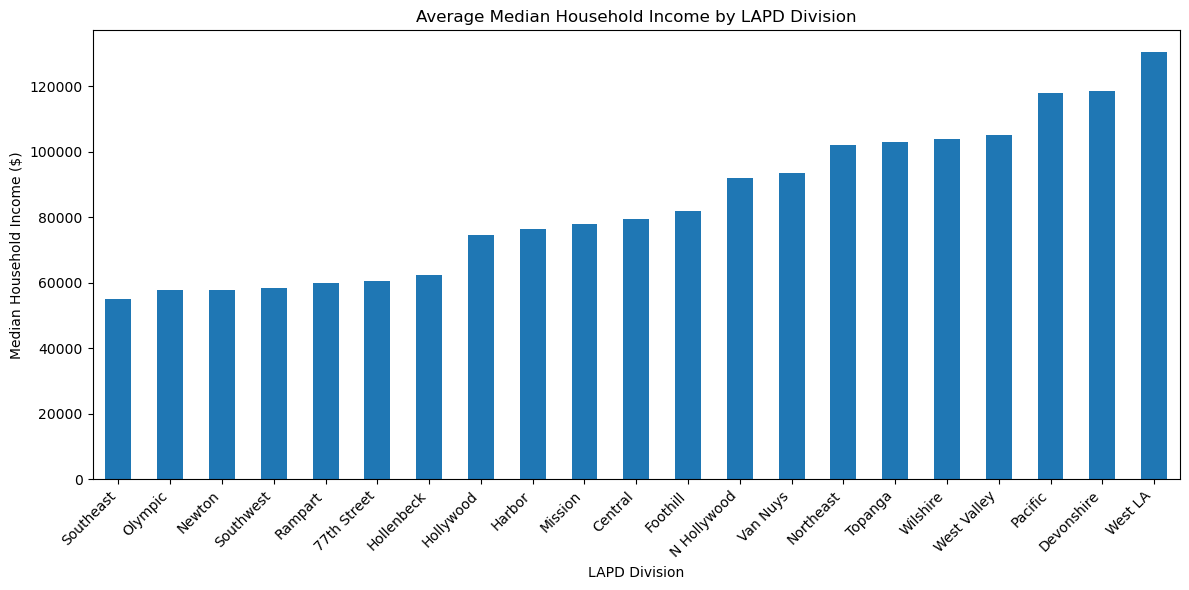

In [26]:
import matplotlib.pyplot as plt

# Compute average income by LAPD division
income_by_area = (
    merged.groupby("AREA NAME")["median_income"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(12, 6))
income_by_area.plot(kind="bar")
plt.title("Average Median Household Income by LAPD Division")
plt.xlabel("LAPD Division")
plt.ylabel("Median Household Income ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Summary Visualization: Average Income by LAPD Division

To explore how socioeconomic context varies across Los Angeles, I created a bar chart showing the average median household income for each LAPD division after merging the ACS income data with the crime dataset.
This visualization shows clear variation across neighborhoods: divisions like Southeast, Olympic, and Newton have lower average household incomes, while West LA, Devonshire, and Pacific have significantly higher income levels.

This matters because socioeconomic inequality may correlate with crime patterns, policing focus, or fairness concerns in predictive modeling. Incorporating these contextual variables helps make the model more interpretable and ensures that later fairness analysis accounts for structural differences between communities.

In [27]:
income_by_area.reset_index().sort_values("median_income")


,AREA NAME,median_income
0,Southeast,54985.958909
1,Olympic,57717.394674
2,Newton,57868.737880
3,Southwest,58372.339077
4,Rampart,59985.125474
5,77th Street,60686.784725
6,Hollenbeck,62261.035189
7,Hollywood,74634.325530
8,Harbor,76441.470116
9,Mission,77788.272102


Step 6: Summary — What Did the External Dataset Add?

Integrating census tract–level ACS data into the LAPD crime dataset added important socioeconomic context that was not present originally. Before merging, the crime dataset only included basic geographic information such as LAPD division and latitude/longitude. After spatially linking crime incidents to census tracts, I was able to attach meaningful attributes about neighborhood conditions.

Specifically, the median household income feature provides insight into broad economic inequality within Los Angeles. By engineering additional features—such as income quartiles, z-scores, and a low-income indicator—I created interpretable measures that help characterize community differences across the city.

This added context allows for deeper questions in later modeling and fairness analysis, such as:

Do prediction errors differ between low-income and high-income neighborhoods?

Are certain types of crimes more concentrated in economically disadvantaged areas?

Does model performance vary across LAPD divisions with different economic profiles?

Overall, the external ACS dataset enriches the crime data by connecting individual incidents to neighborhood-level socioeconomic conditions. This will allow for more meaningful analysis, improved model interpretability, and a clearer understanding of how structural factors may relate to crime patterns.